In [1]:
import awkward as ak
import numpy as np
import time
import coffea
import pickle
import hist

print(coffea.__version__)
from coffea import util
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea import util, processor
from plugins import handleData
from utils import *
import hist

0.7.22


In [2]:
#### based on https://github.com/rappoccio/TUnfoldExamples/blob/master/tunfoldsys_example-2d.ipynb
dataset_cat = hist.axis.StrCategory([],growth=True,name="dataset", label="Dataset")
mgen_bin_edges = np.array([0,1,5,10,20,40,60,80,100,150,200,250,1000])
mreco_bin_edges = np.sort(np.append(mgen_bin_edges,[(mgen_bin_edges[i]+mgen_bin_edges[i+1])/2 for i in range(len(mgen_bin_edges)-1)]))                       
mass_bin = hist.axis.Variable(mreco_bin_edges, name="mreco", label=r"FAKE m_{RECO} (GeV)")
mass_gen_bin =  hist.axis.Variable(mgen_bin_edges, name="mgen", label=r"FAKE m_{GEN} (GeV)") 
pt_bin = hist.axis.Variable([200,280,360,450,520,630,690,750,800,1300,13000], name="ptreco", label=r"p_{T,RECO} (GeV)")        
pt_gen_bin = hist.axis.Variable([200,280,360,450,520,630,690,750,800,1300,13000], name="ptgen", label=r"p_{T,GEN} (GeV)") 
result = {
    #### Plots to be unfolded
    'jet_pt_mass_reco_u':       hist.Hist(dataset_cat, pt_bin, mass_bin, storage="weight", name="Events"),
    'jet_pt_mass_reco_g':        hist.Hist(dataset_cat, pt_bin, mass_bin, storage="weight", name="Events"),
    'fakes':        hist.Hist(dataset_cat, pt_bin, mass_bin, storage="weight", name="Events"),
    #### Plots for comparison
    'jet_pt_mass_u_gen':        hist.Hist(dataset_cat, pt_gen_bin, mass_gen_bin, storage="weight", label="Events"),
    'jet_pt_mass_g_gen':            hist.Hist(dataset_cat, pt_gen_bin, mass_gen_bin, storage="weight", label="Events"),
    'misses':            hist.Hist(dataset_cat, pt_gen_bin, mass_gen_bin, storage="weight", label="Events"),   
    #### Plots for the analysis in the proper binning
    'response_matrix_u':    hist.Hist(dataset_cat, pt_bin, mass_bin, pt_gen_bin, mass_gen_bin, storage="weight", label="Events"),
    'response_matrix_g':     hist.Hist(dataset_cat, pt_bin, mass_bin, pt_gen_bin, mass_gen_bin, storage="weight", label="Events"),
    'response_matrix_errU':    hist.Hist(dataset_cat, pt_bin, mass_bin, pt_gen_bin, mass_gen_bin, storage="weight", label="Events"),
    'response_matrix_errD':     hist.Hist(dataset_cat, pt_bin, mass_bin, pt_gen_bin, mass_gen_bin, storage="weight", label="Events"),
    }
dataset = "FAKE"
nev = 10000000 # 100000
xavg = 100.
yavg = 80.
xres = 10.
yres = 10.
gen_pt = np.random.poisson(xavg, nev) + 0.5*np.random.normal(200, 500, nev)
reco_pt = (np.random.randn(nev)*xres)+gen_pt
gen_m = np.random.normal(yavg, 50, nev)+np.random.poisson(yavg, nev)
reco_m = np.random.normal(10, 50, nev)*np.random.randn(nev)+gen_m

miss_pt = np.random.poisson(xavg, nev)+ np.random.normal(xavg, 200, nev)
miss_m = np.random.normal(yavg, 50, nev)+np.random.poisson(yavg, nev)
fake_pt = (np.random.randn(1000)*xres)+np.random.poisson(xavg, 1000)+ np.random.normal(xavg, 200, 1000)
fake_m = np.random.normal(10, 50, 1000)*np.random.randn(1000)+np.random.normal(yavg, 50, 1000)+np.random.poisson(yavg, 1000)

error_scaleUp = 1.10
error_scaleDn = 0.90

reco_mu = reco_m*error_scaleUp
reco_md = reco_m*error_scaleDn


print(reco_m)
####plots
result['jet_pt_mass_u_gen'].fill( dataset=dataset, ptgen=gen_pt, mgen=gen_m )
result['jet_pt_mass_g_gen'].fill( dataset=dataset, ptgen=gen_pt, mgen=gen_m )
result["response_matrix_u"].fill( dataset=dataset, ptreco=reco_pt, ptgen=gen_pt, mreco=reco_m, mgen=gen_m )
result["response_matrix_g"].fill( dataset=dataset, ptreco=reco_pt, ptgen=gen_pt, mreco=reco_m, mgen=gen_m )
result["response_matrix_errU"].fill( dataset=dataset, ptreco=reco_pt, ptgen=gen_pt, mreco=reco_mu, mgen=gen_m )
result["response_matrix_errD"].fill( dataset=dataset, ptreco=reco_pt, ptgen=gen_pt, mreco=reco_md, mgen=gen_m )
result["jet_pt_mass_reco_u"].fill( dataset=dataset, ptreco=reco_pt, mreco=reco_m )
result["jet_pt_mass_reco_g"].fill( dataset=dataset, ptreco=reco_pt, mreco=reco_m )
result["misses"].fill( dataset=dataset, ptgen=miss_pt, mgen=miss_m )
result["fakes"].fill( dataset=dataset, ptreco=fake_pt, mreco=fake_m )

[267.34990968 183.48633554 224.2100516  ...  -7.61893901  63.60174965
 229.60157658]


Hist(
  StrCategory(['FAKE'], growth=True, name='dataset', label='Dataset'),
  Variable([200, 280, 360, 450, 520, 630, 690, 750, 800, 1300, 13000], name='ptreco', label='p_{T,RECO} (GeV)'),
  Variable(array([0.00e+00, 5.00e-01, 1.00e+00, 3.00e+00, 5.00e+00, 7.50e+00,
       1.00e+01, 1.50e+01, 2.00e+01, 3.00e+01, 4.00e+01, 5.00e+01,
       6.00e+01, 7.00e+01, 8.00e+01, 9.00e+01, 1.00e+02, 1.25e+02,
       1.50e+02, 1.75e+02, 2.00e+02, 2.25e+02, 2.50e+02, 6.25e+02,
       1.00e+03]), name='mreco', label='FAKE m_{RECO} (GeV)'),
  storage=Weight()) # Sum: WeightedSum(value=508, variance=508) (WeightedSum(value=1000, variance=1000) with flow)

In [3]:
fname = "coffeaOutput/fakeHists.pkl"
with open(fname, "wb") as f:
    pickle.dump( result, f)

In [4]:
fname = "coffeaOutput/fakeHists_ref.pkl"
with open(fname, "rb") as f:
    result = pickle.load( f )

10


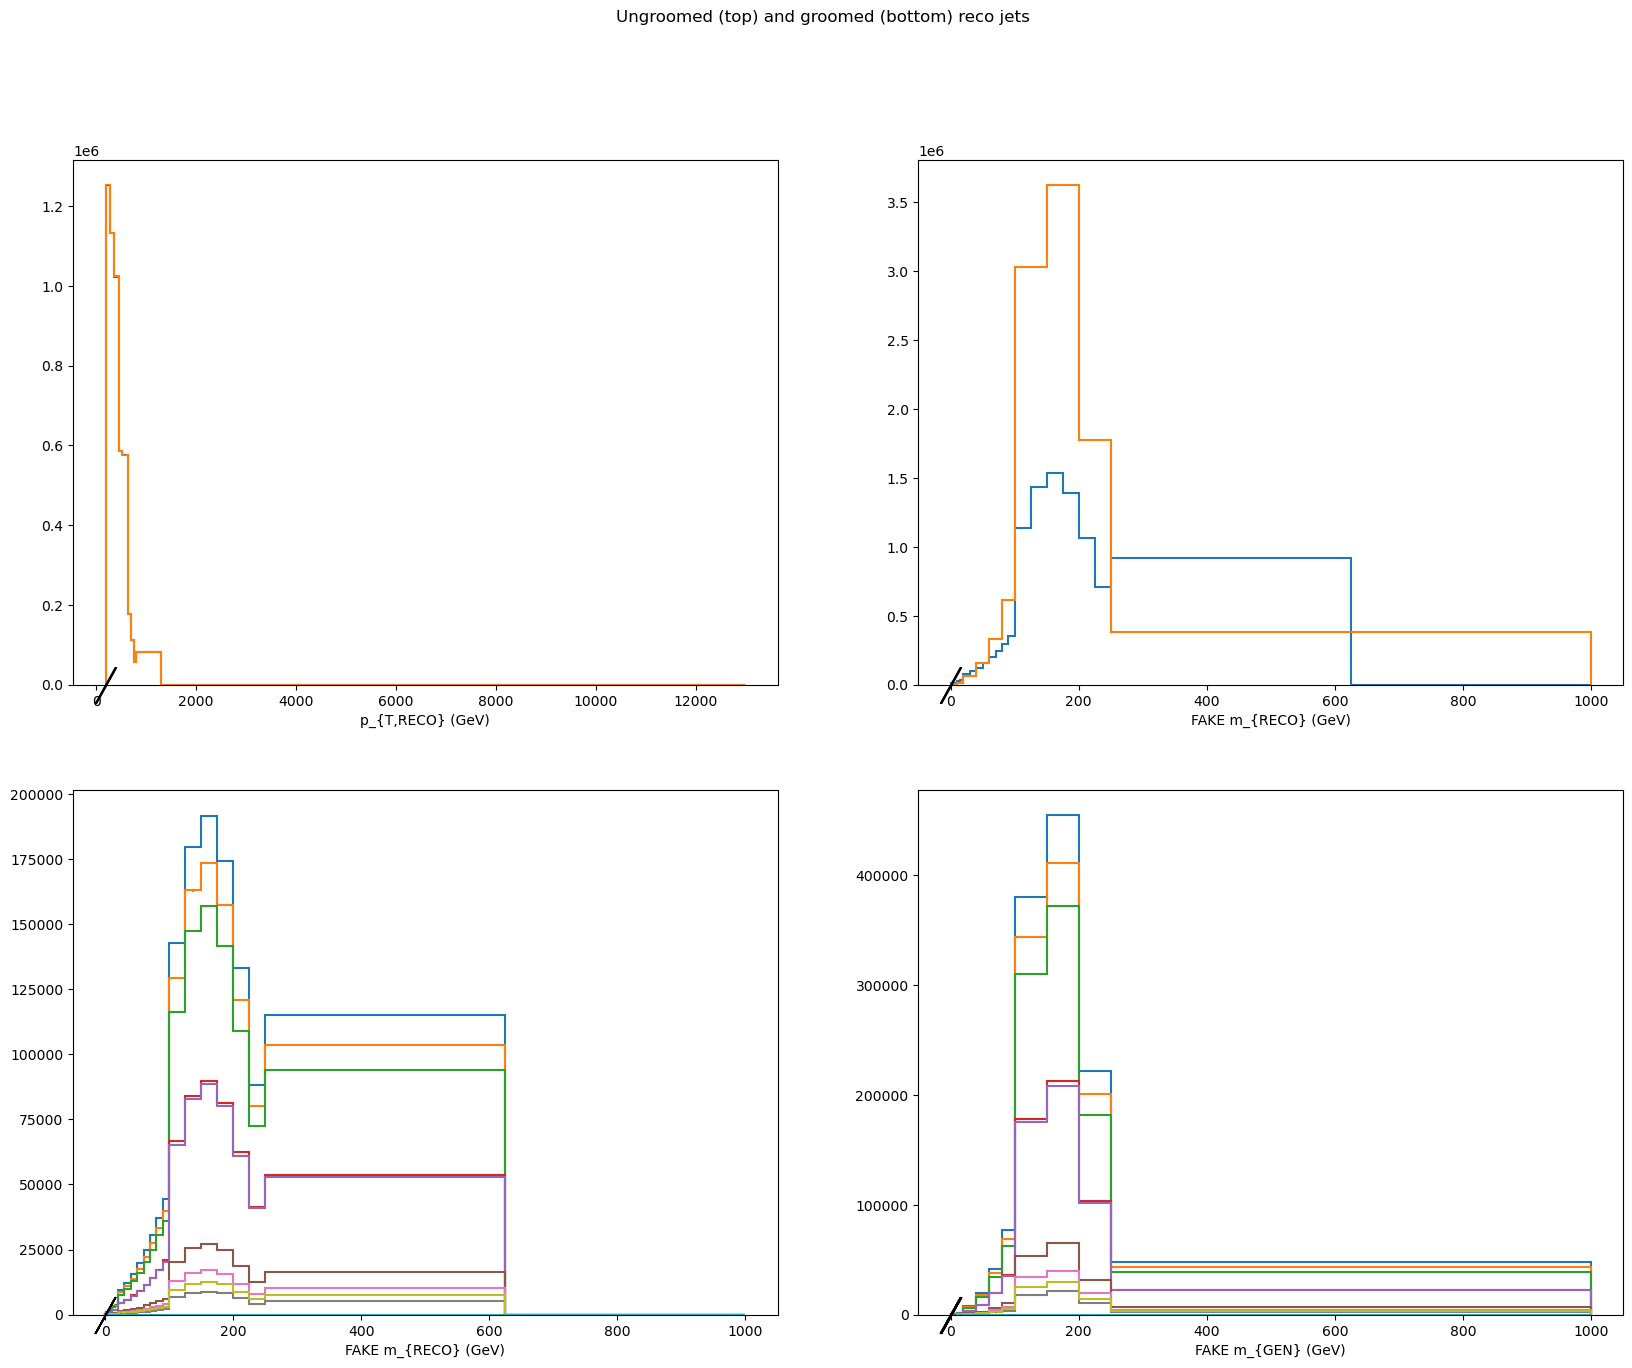

In [5]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,15)
fig, axs = plt.subplots(2, 2)
fig.suptitle('Ungroomed (top) and groomed (bottom) reco jets')
result['jet_pt_mass_reco_u'].project('ptreco').plot1d(ax=axs[0,0])
result['jet_pt_mass_reco_u'].project('mreco').plot1d(ax=axs[0,1])
result['jet_pt_mass_u_gen'].project('ptgen').plot1d(ax=axs[0,0])
result['jet_pt_mass_u_gen'].project('mgen').plot1d(ax=axs[0,1])
response_matrix_u_values, ptreco_edges, mreco_edges, ptgen_edges, mgen_edges = result['response_matrix_u'].project("ptreco", "mreco", "ptgen", "mgen").to_numpy()
print(len(ptreco_edges)-1)
for i in range(len(ptreco_edges)-1):
    result['response_matrix_u'][{'dataset':sum, 'ptreco':i}].project('mreco').plot1d(ax=axs[1,0])
for i in range(len(ptgen_edges)-1):
    result['response_matrix_u'][{'ptgen':i}].project('mgen').plot1d(ax=axs[1,1])
# result['response_matrix_u'].project('mreco').plot1d(ax=axs[1,1])
# result['jet_pt_mass_reco_u'].project('mreco').plot1d(ax=axs[1,1])
# axs[0,0].set_yscale('log')
# axs[1,0].set_yscale('log')
# axs[1,1].set_yscale('log')
# axs[0,1].set_yscale('log')
# plt.savefig(os_path+"/test_pt_m_gen_u_g.png")

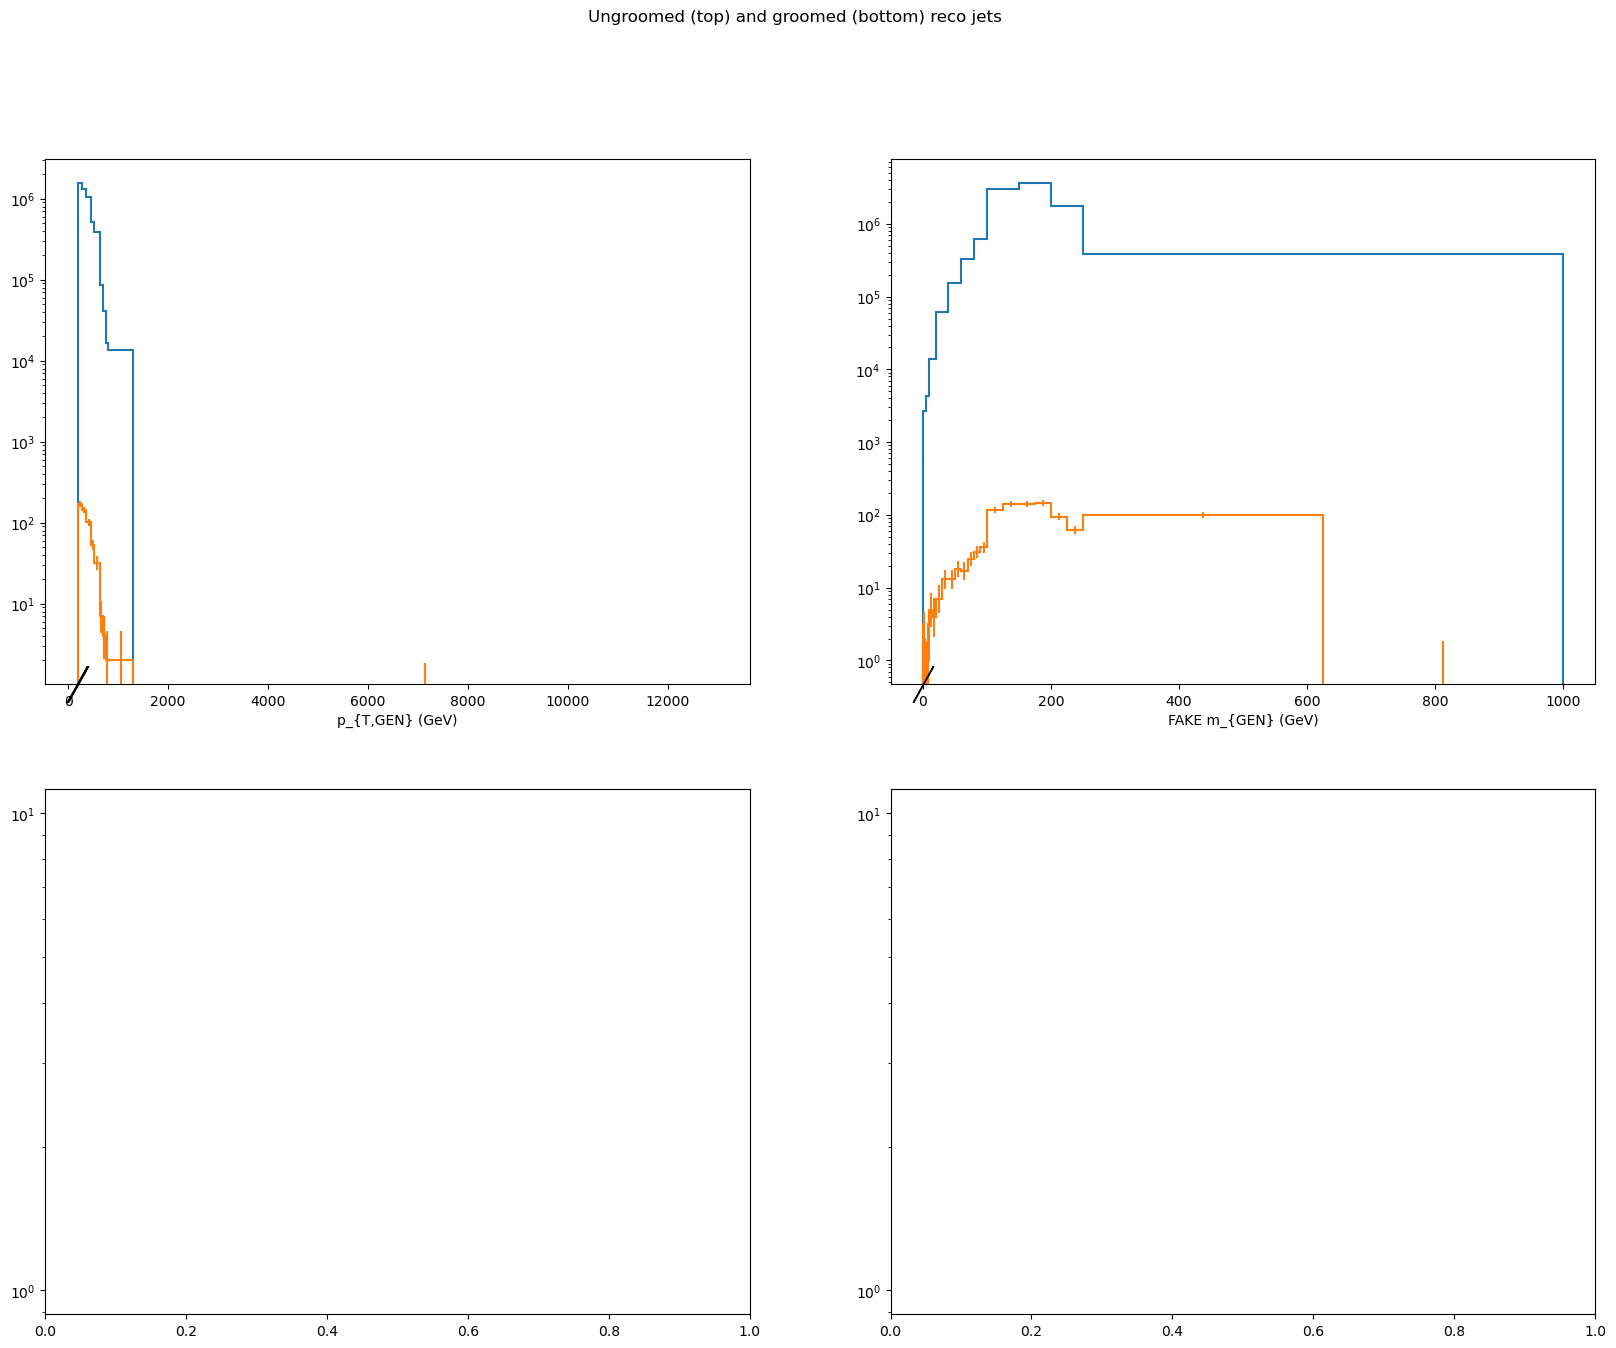

In [6]:
plt.rcParams["figure.figsize"] = (20,15)
fig, axs = plt.subplots(2, 2)
fig.suptitle('Ungroomed (top) and groomed (bottom) reco jets')
result['misses'][{'dataset':sum}].project('ptgen').plot1d(ax=axs[0,0])
result['misses'][{'dataset':sum}].project('mgen').plot1d(ax=axs[0,1])
result['fakes'][{'dataset':sum}].project('ptreco').plot1d(ax=axs[0,0])
result['fakes'][{'dataset':sum}].project('mreco').plot1d(ax=axs[0,1])
axs[0,0].set_yscale('log')
axs[1,0].set_yscale('log')
axs[1,1].set_yscale('log')
axs[0,1].set_yscale('log')

In [7]:
#### make root file

In [8]:
import uproot
# rootfile = uproot.recreate('fakeHists_arr.root')
response_matrix_u_values, ptreco_edges, mreco_edges, ptgen_edges, mgen_edges = result['response_matrix_u'].project("ptreco", "mreco", "ptgen", "mgen").to_numpy()
response_matrix_g_values = result['response_matrix_g'].project("ptreco", "mreco", "ptgen", "mgen").values()
response_matrix_errU_values = result['response_matrix_errU'].project("ptreco", "mreco", "ptgen", "mgen").values()
response_matrix_errD_values = result['response_matrix_errD'].project("ptreco", "mreco", "ptgen", "mgen").values()
ptgen_mgen_u_values = result['response_matrix_u'].project("ptgen", "mgen").values()
ptgen_mgen_g_values = result['response_matrix_g'].project("ptgen", "mgen").values()
misses_values = result['misses'].project("ptgen", "mgen").values()
ptreco_mreco_u_values = result['jet_pt_mass_reco_u'][{'dataset':sum}].values()
ptreco_mreco_g_values =  result['jet_pt_mass_reco_g'][{'dataset':sum}].values()
fakes_values = result['fakes'].project("ptreco", "mreco").values()
print(response_matrix_g_values.shape)
ptreco_centers = (ptreco_edges[:-1]+ptreco_edges[1:])/2
mreco_centers = (mreco_edges[:-1]+mreco_edges[1:])/2
ptgen_centers = (ptgen_edges[:-1]+ptgen_edges[1:])/2
mgen_centers = (mgen_edges[:-1]+mgen_edges[1:])/2
print(ptreco_centers[np.newaxis])
print(ptgen_centers[np.newaxis])
print(mreco_centers[np.newaxis])
print(mgen_centers[np.newaxis])
rootfile['response'] = {'groomed':response_matrix_g_values[np.newaxis], 
                        'ungroomed':response_matrix_u_values[np.newaxis],
                       'errorUp':response_matrix_errU_values[np.newaxis], 
                        'errorDown':response_matrix_errD_values[np.newaxis]}
rootfile['centers'] = {'ptreco':ptreco_centers[np.newaxis], 'mreco':mreco_centers[np.newaxis], 
                  'ptgen':ptgen_centers[np.newaxis], 'mgen':mgen_centers[np.newaxis]}
rootfile['reco'] = {'groomed':ptreco_mreco_g_values[np.newaxis] , 'ungroomed':ptreco_mreco_u_values[np.newaxis], 'fakes':fakes_values[np.newaxis]}
rootfile['gen'] = {'groomed':ptgen_mgen_g_values[np.newaxis], 'ungroomed':ptgen_mgen_u_values[np.newaxis], 'misses':misses_values[np.newaxis]}
rootfile['ptgen_mgen_u'] = result['response_matrix_u'].project("ptgen", "mgen")
rootfile['ptgen_mgen_g'] = result['response_matrix_g'].project("ptgen","mgen")
rootfile['jet_ptreco_mreco_u'] = result['jet_pt_mass_reco_u'][{'dataset':sum}]
rootfile['jet_ptreco_mreco_g'] = result['jet_pt_mass_reco_g'][{'dataset':sum}]
rootfile['jet_ptreco_mreco_up'] = result['response_matrix_errU'].project("ptreco", "mreco")
rootfile['jet_ptreco_mreco_down'] = result['response_matrix_errD'].project("ptreco", "mreco")
rootfile['misses_ptgen_mgen'] = result['misses'].project("ptgen", "mgen")
rootfile['fakes_ptreco_mreco'] = result['fakes'].project("ptreco","mreco")
rootfile.close()

(10, 24, 10, 12)
[[ 240.  320.  405.  485.  575.  660.  720.  775. 1050. 7150.]]
[[ 240.  320.  405.  485.  575.  660.  720.  775. 1050. 7150.]]
[[2.500e-01 7.500e-01 2.000e+00 4.000e+00 6.250e+00 8.750e+00 1.250e+01
  1.750e+01 2.500e+01 3.500e+01 4.500e+01 5.500e+01 6.500e+01 7.500e+01
  8.500e+01 9.500e+01 1.125e+02 1.375e+02 1.625e+02 1.875e+02 2.125e+02
  2.375e+02 4.375e+02 8.125e+02]]
[[5.00e-01 3.00e+00 7.50e+00 1.50e+01 3.00e+01 5.00e+01 7.00e+01 9.00e+01
  1.25e+02 1.75e+02 2.25e+02 6.25e+02]]


NameError: name 'rootfile' is not defined

WeightedSum(value=2, variance=2)


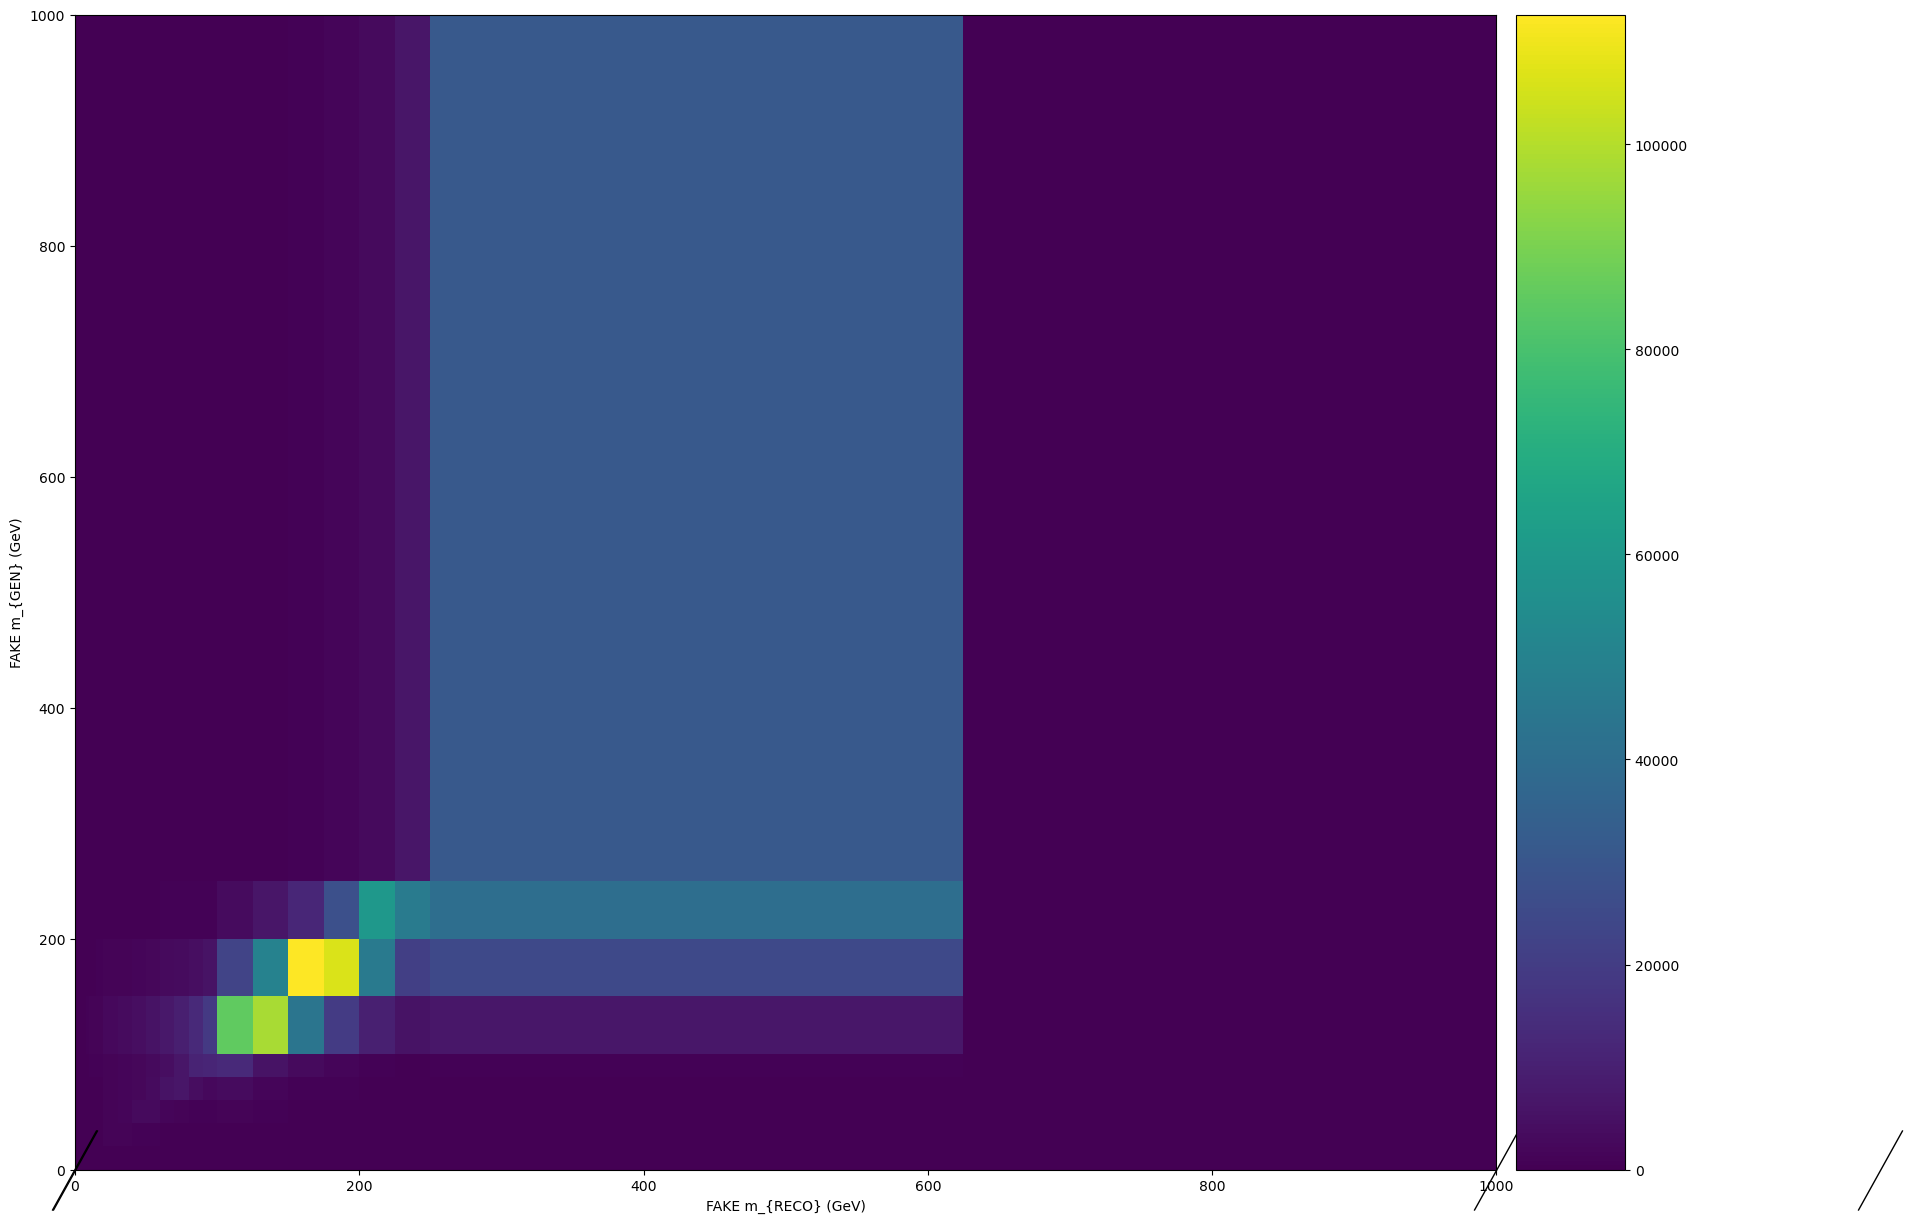

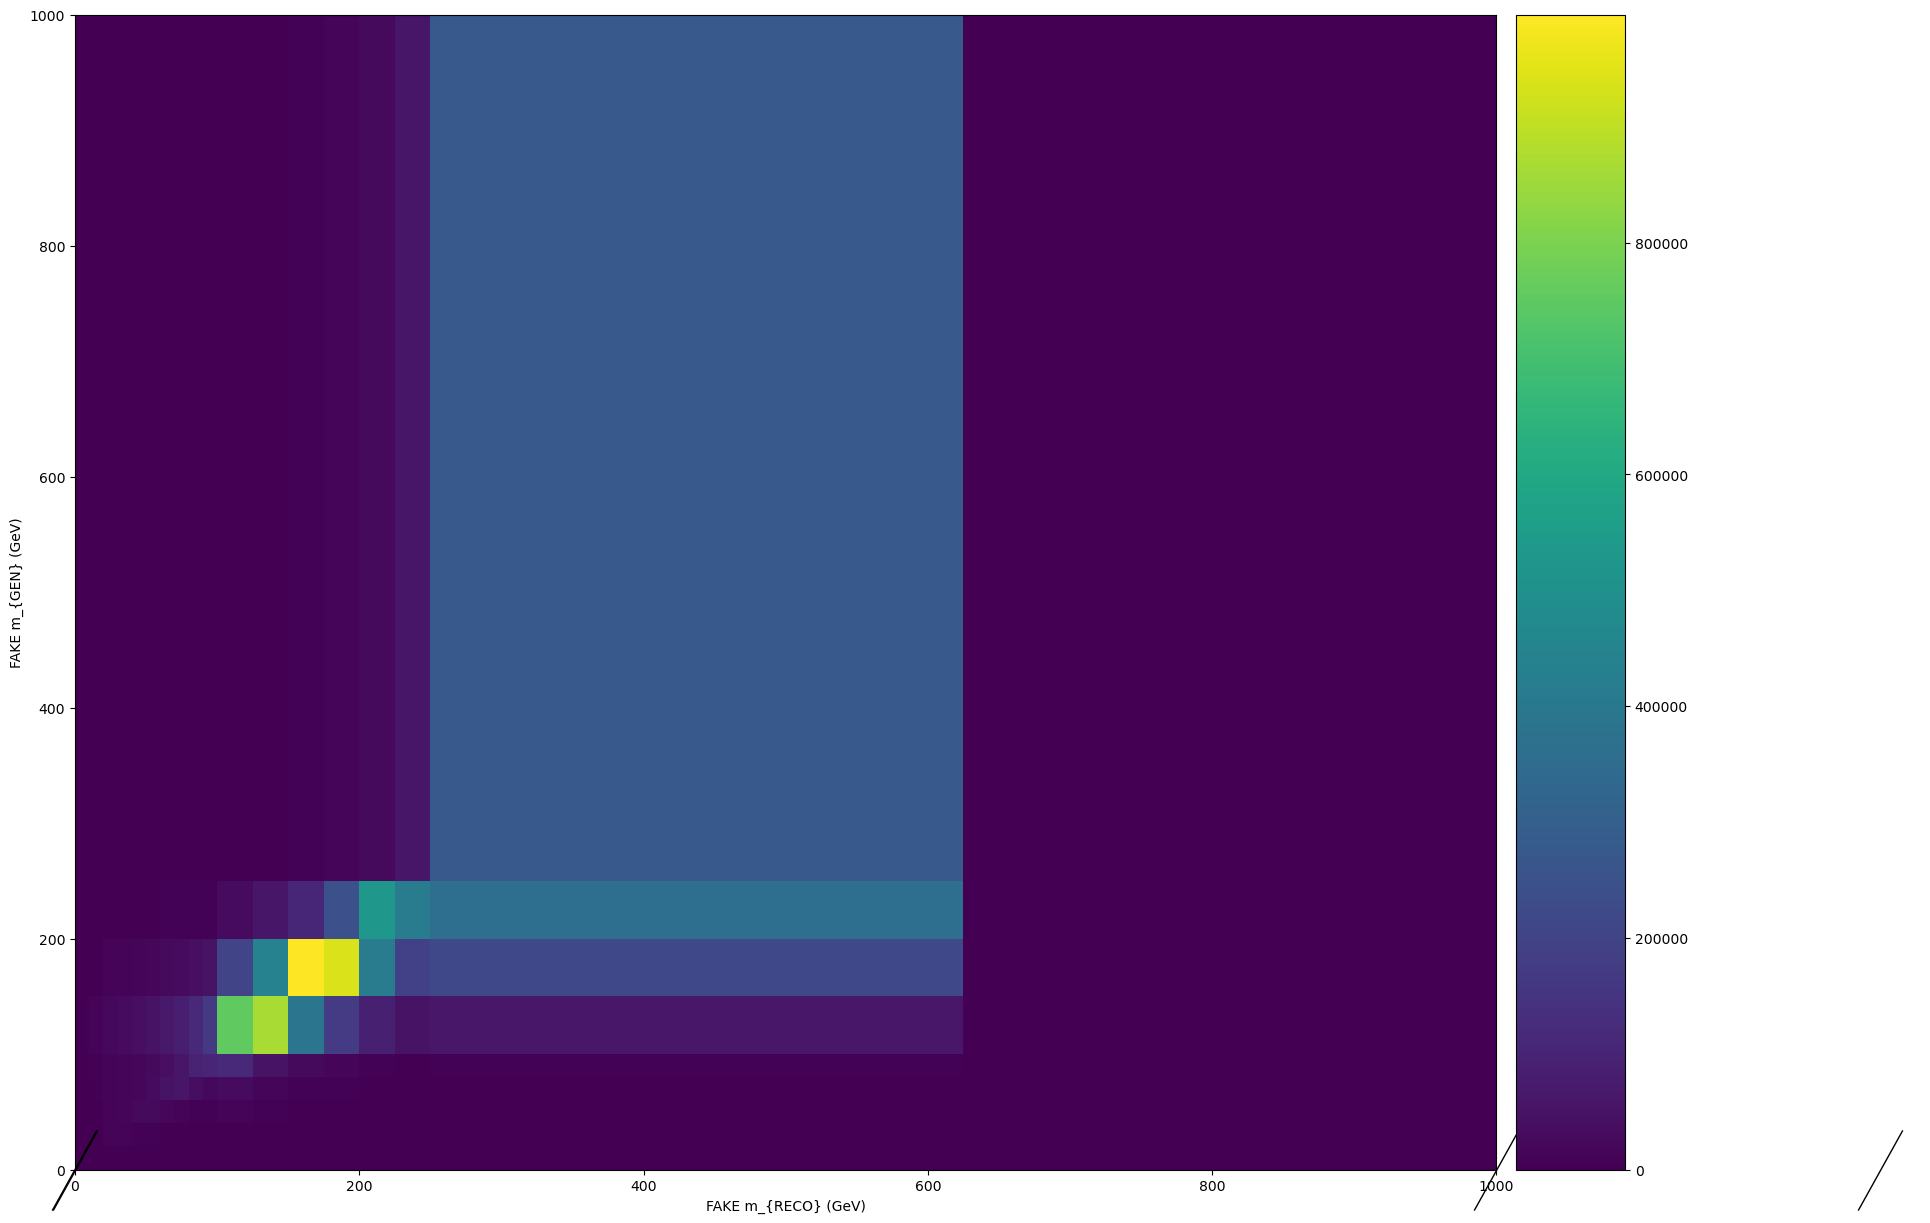

(10, 24, 10, 12)


In [9]:
response_matrix_u_values = result['response_matrix_u'].project("ptreco", "mreco", "ptgen", "mgen").values()
response_matrix_g_values = result['response_matrix_g'].project("ptreco", "mreco", "ptgen", "mgen").values()
print(result['response_matrix_u'][{"ptreco":1, "ptgen":2,"mreco":5, "mgen":10, "dataset":sum}])
response_matrix_np_vals_u, ptreco_edges, mreco_edges, ptgen_edges, mgen_edges = result['response_matrix_u'].project("ptreco", "mreco", "ptgen", "mgen").to_numpy()
result['response_matrix_u'][{"ptreco":0, "ptgen":0,"dataset":sum}].plot2d()
plt.show()
result['response_matrix_u'][{"ptreco":sum, "ptgen":sum,"dataset":sum}].plot2d()
plt.show()
nptreco,nmassreco,nptgen,nmassgen = response_matrix_u_values.shape
print(response_matrix_u_values.shape)
response_matrix_g_final = response_matrix_g_values.reshape( (nptreco)*(nmassreco), (nptgen)*(nmassgen) )
response_matrix_u_final = response_matrix_u_values.reshape( (nptreco)*(nmassreco), (nptgen)*(nmassgen) ) 
response_matrix_errU_final = response_matrix_errU_values.reshape( (nptreco)*(nmassreco), (nptgen)*(nmassgen) )
response_matrix_errD_final = response_matrix_errD_values.reshape( (nptreco)*(nmassreco), (nptgen)*(nmassgen) )



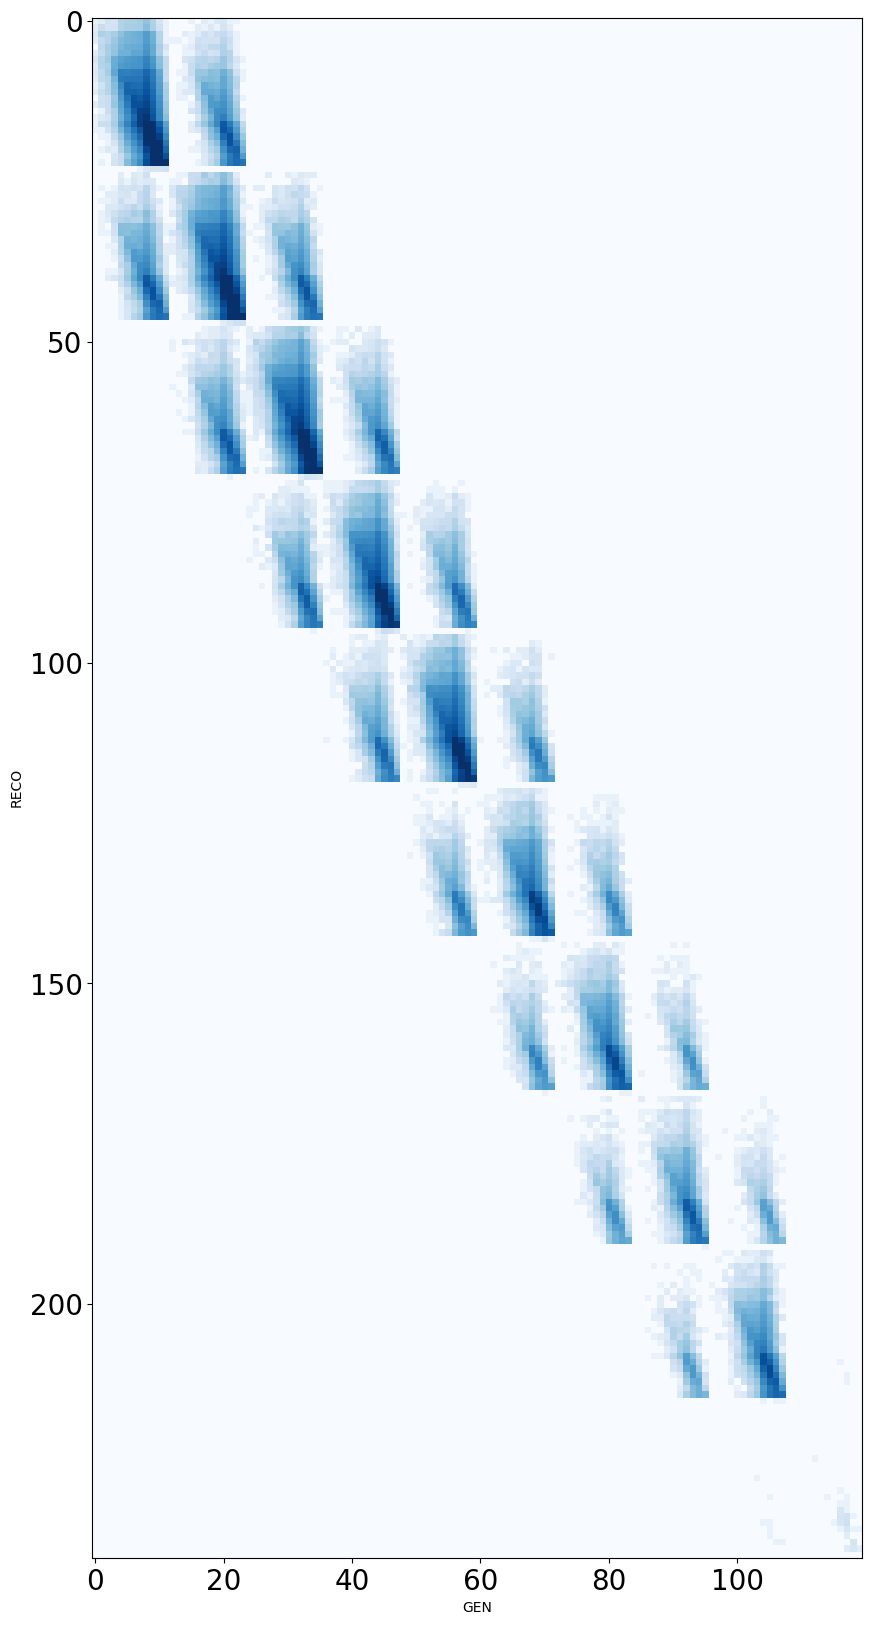

In [10]:
plt.figure(figsize = (20,20))
plt.imshow( np.log(response_matrix_u_final+1), vmax=10, aspect="equal", cmap="Blues" )
plt.xlabel("GEN", fontsize=10)
plt.ylabel("RECO", fontsize=10)
plt.tick_params(labelsize=20)

/tmp/ipykernel_229/3454855758.py:3: RuntimeWarning: divide by zero encountered in log
  axs[0].imshow( np.log(response_matrix_errU_final),vmax=10, aspect="equal", cmap="Blues" )
/tmp/ipykernel_229/3454855758.py:4: RuntimeWarning: divide by zero encountered in log
  axs[1].imshow( np.log(response_matrix_errU_final), vmax=10, aspect="equal", cmap="Blues" )


<Figure size 2000x2000 with 0 Axes>

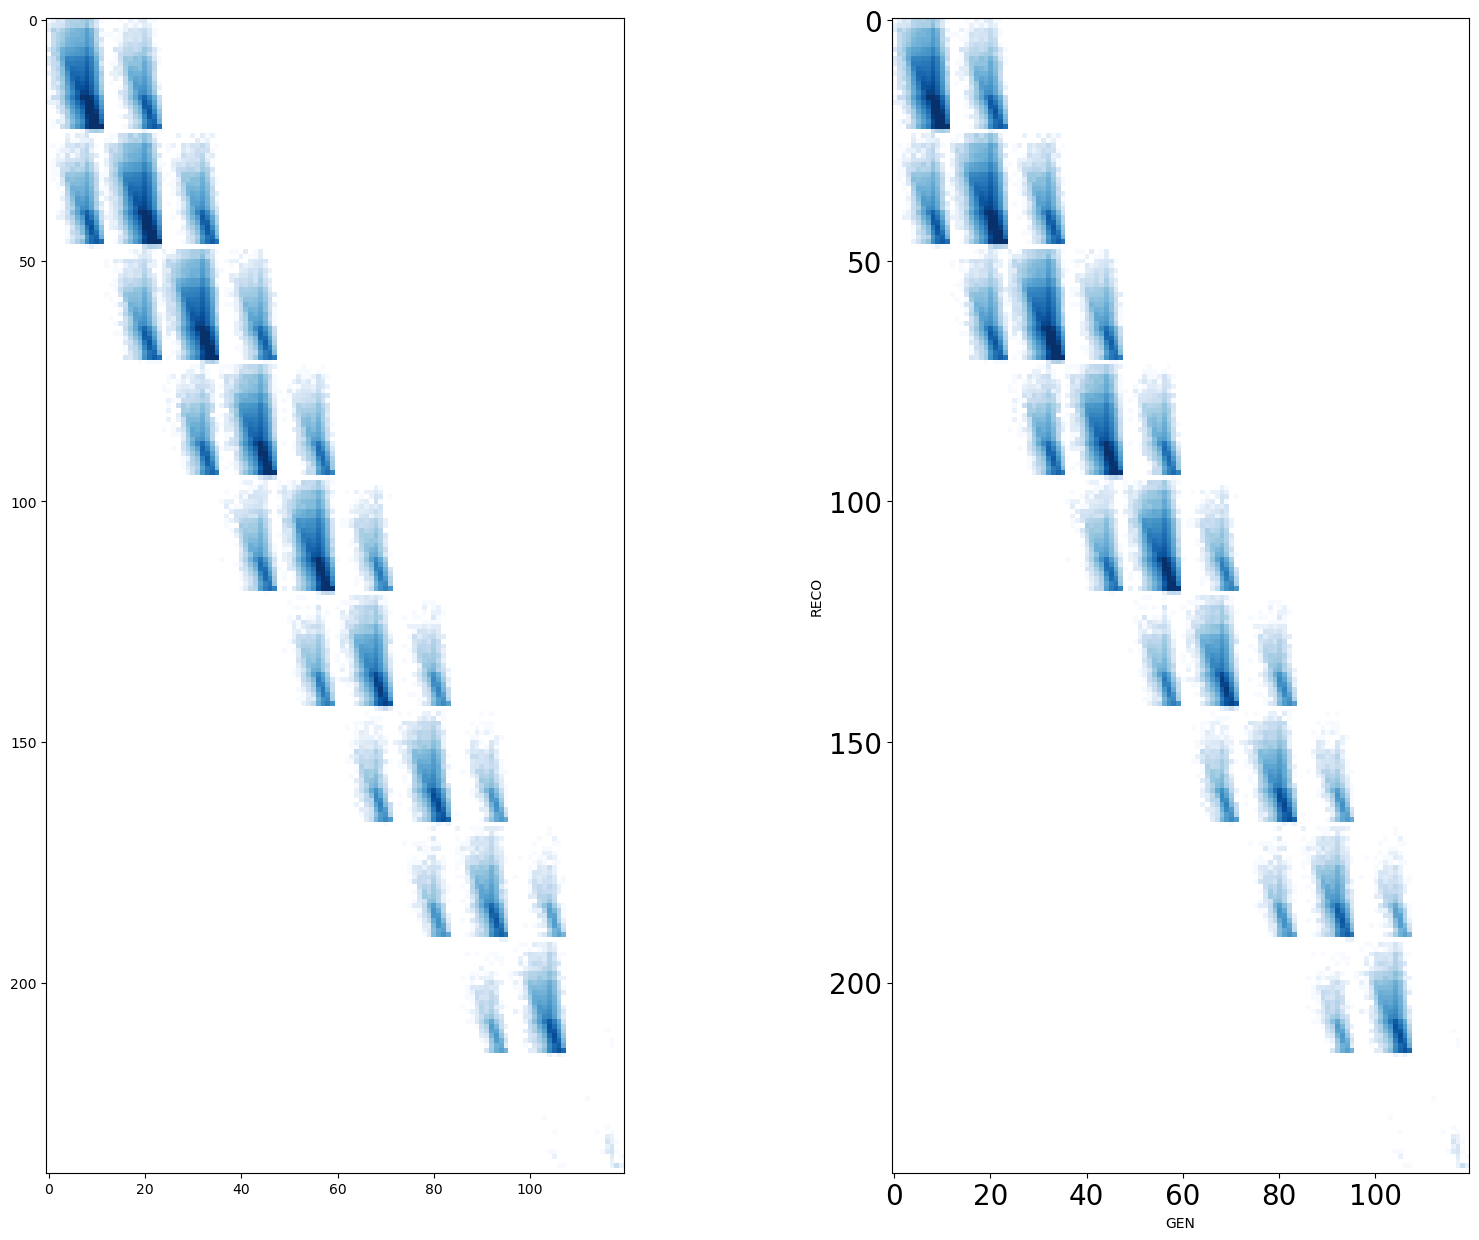

In [11]:
plt.figure(figsize = (20,20))
fig, axs = plt.subplots(1, 2)
axs[0].imshow( np.log(response_matrix_errU_final),vmax=10, aspect="equal", cmap="Blues" )
axs[1].imshow( np.log(response_matrix_errU_final), vmax=10, aspect="equal", cmap="Blues" )
plt.xlabel("GEN", fontsize=10)
plt.ylabel("RECO", fontsize=10)
plt.tick_params(labelsize=20)

In [14]:
hists = uproot.open('fakeHists_arr.root')
ptgen_mgen_flat = hists['gen']['ungroomed'].array().to_numpy().flatten()
ptreco_mreco_flat = hists['reco']['ungroomed'].array().to_numpy().flatten()
ptgen_centers = hists['centers']['ptgen'].array().to_numpy().flatten()
mgen_centers = hists['centers']['mgen'].array().to_numpy().flatten()
ptgen_mgen_vals, ptgen_bins, mgen_bins = hists['ptgen_mgen_u'].to_numpy()
ptreco_mreco_vals, ptreco_bins, mreco_bins = hists['jet_ptreco_mreco_u'].to_numpy()
print(ptgen_mgen_vals.reshape((len(ptgen_centers), len(mgen_centers))))
for i in np.arange(len(ptreco_bins)-1):
    for j in np.arange(len(mreco_bins)-1):
        print("ptreco bin: ", i, " mreco bin ", j, "global reco bin: ", i*(len(mreco_bins)-1)+j )
        # print(ptgen_mgen_vals[i, j])
        # print(ptgen_mgen_flat[i*len(mgen_centers)+j])
        print(ptreco_mreco_vals[i, j])
        print(ptreco_mreco_flat[i*(len(mreco_bins)-1)+j])
print("Reco max: ", np.max(ptreco_mreco_flat))
for i in np.arange(len(ptgen_bins)-1):
    for j in np.arange(len(mgen_bins)-1):
        print("ptgen bin: ", i, " mgen bin ", j, "global gen bin: ", i*(len(mgen_bins)-1)+j )
        # print(ptgen_mgen_vals[i, j])
        # print(ptgen_mgen_flat[i*len(mgen_centers)+j])
        print(ptgen_mgen_vals[i, j])
        print(ptgen_mgen_flat[i*(len(mgen_bins)-1)+j])
print(np.max(ptgen_mgen_flat))

[[7.60000e+01 3.40000e+02 5.45000e+02 1.65000e+03 7.66000e+03 1.94710e+04
  4.15010e+04 7.62990e+04 3.81366e+05 4.53833e+05 2.23353e+05 4.81370e+04]
 [6.30000e+01 2.71000e+02 5.50000e+02 1.55600e+03 7.12500e+03 1.76140e+04
  3.75070e+04 6.89780e+04 3.44364e+05 4.11417e+05 2.00810e+05 4.33450e+04]
 [6.20000e+01 2.73000e+02 4.18000e+02 1.38100e+03 6.19800e+03 1.57120e+04
  3.41650e+04 6.27450e+04 3.10179e+05 3.71976e+05 1.80671e+05 3.92020e+04]
 [2.50000e+01 1.69000e+02 2.54000e+02 8.32000e+02 3.59900e+03 8.87400e+03
  1.94390e+04 3.52880e+04 1.76625e+05 2.11129e+05 1.03331e+05 2.22220e+04]
 [3.00000e+01 1.43000e+02 2.27000e+02 7.90000e+02 3.52000e+03 8.73900e+03
  1.89030e+04 3.51710e+04 1.74542e+05 2.09055e+05 1.01963e+05 2.19530e+04]
 [7.00000e+00 4.30000e+01 7.30000e+01 2.23000e+02 1.07100e+03 2.67700e+03
  5.84300e+03 1.06750e+04 5.38280e+04 6.41550e+04 3.14600e+04 6.75100e+03]
 [5.00000e+00 3.40000e+01 3.90000e+01 1.45000e+02 6.91000e+02 1.67900e+03
  3.64200e+03 6.65200e+03 3.4111